## Pediatric ALL DEG analysis
---

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import zscore
import numpy as np
import math

import rpy2.rinterface
#ipython extension
%load_ext rpy2.ipython
from rpy2.robjects import pandas2ri
pandas2ri.activate()

#seaborn Gr-Bk-Rd palette
pal = sns.diverging_palette(127.7, 12.2, l=53.4, n=255, center="dark")

#font scale
sns.set(font_scale=1.3)


#DEG cutoff func.
pval = 0.001
logfc = math.log2(1.2)

def degpl(deg):
    m = deg['P.Value'] < pval
    m_pl = deg['logFC'] > logfc
    
    deg_pl = deg[m][m_pl]
    
    print('deg_pl: ', deg_pl.shape)
    return deg_pl

def degmi(deg):
    m = deg['P.Value'] < pval
    m_mi = deg['logFC'] < -logfc
    
    deg_mi = deg[m][m_mi]
    print('deg_mi: ', deg_mi.shape)
    return deg_mi

def plotprocess():
    res['logPV'] = res['P.Value'].apply(lambda x: -(math.log10(x)))

    res['type'] = 'etc'

    logfc = math.log2(1.2)

    for i in res.index:
        if res.get_value(i, 'P.Value') < 0.001:
            if res.get_value(i, 'logFC') > logfc:
                res.set_value(i, 'type', 'pl')
            elif res.get_value(i, 'logFC') < -logfc:
                res.set_value(i, 'type', 'mi')

---
## GSE28460

In [2]:
%%R
#DEG analysis
library(GEOquery)
library(limma)

gse <- getGEO("GSE28460",GSEMatrix=TRUE)
gse <- gse[[1]]

#exp data
eset <- exprs(gse)

#probe id to gene symbol
fset <- fData(gse)

symbols <- fset[,"Gene Symbol"]
rownames(eset) <- symbols

pset <- phenoData(gse)

eset2 <- log2(eset)
pset3 = pset

grp <- pset3$'source_name_ch1'
design <- model.matrix(~0 + grp)
design = design[,1:2]
colnames(design)

colnames(design) <- c("diagnosis","relapse")

#fit
fit <- lmFit(eset2,design)
cont <- makeContrasts(relapse-diagnosis,levels=design)
fit.cont <- contrasts.fit(fit,cont)
fit.cont <- eBayes(fit.cont)
res <- topTable(fit.cont,number=Inf)

#data output
write.csv(res, file="./28460/res.csv")


#eset for visualization
genes = c('SHCBP1', 'CENPN', 'KIF2C', 'MKI67', 'NCAPH', 'FOXM1', 'E2F8')

eset28460 = log2(eset[genes,])

eset_d = eset28460[,pset$'source_name_ch1' == 'diagnosis']
eset_r = eset28460[,pset$'source_name_ch1' == 'relapse']

# esets = data.frame('Diagnodis' = rowMeans(eset_d), 'Relapse' = rowMeans(eset_r))
# eset28460 = data.frame(t(eset28460))

# write.csv(esets, file='./28460/esets.csv')
# write.csv(eset28460, file='./28460/eset28460.csv')


write.csv(eset_d, file='./28460/esets_d.csv')
write.csv(eset_r, file='./28460/esets_r.csv')

In [3]:
#DEG cutoff
deg = pd.read_csv('./28460/res.csv')

print('deg----------------------------')
deg_pl = degpl(deg)
deg_mi = degmi(deg)

deg_pl.to_csv('./28460/deg_pl.csv')
deg_mi.to_csv('./28460/deg_mi.csv')

deg----------------------------
deg_pl:  (162, 8)
deg_mi:  (42, 8)


C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


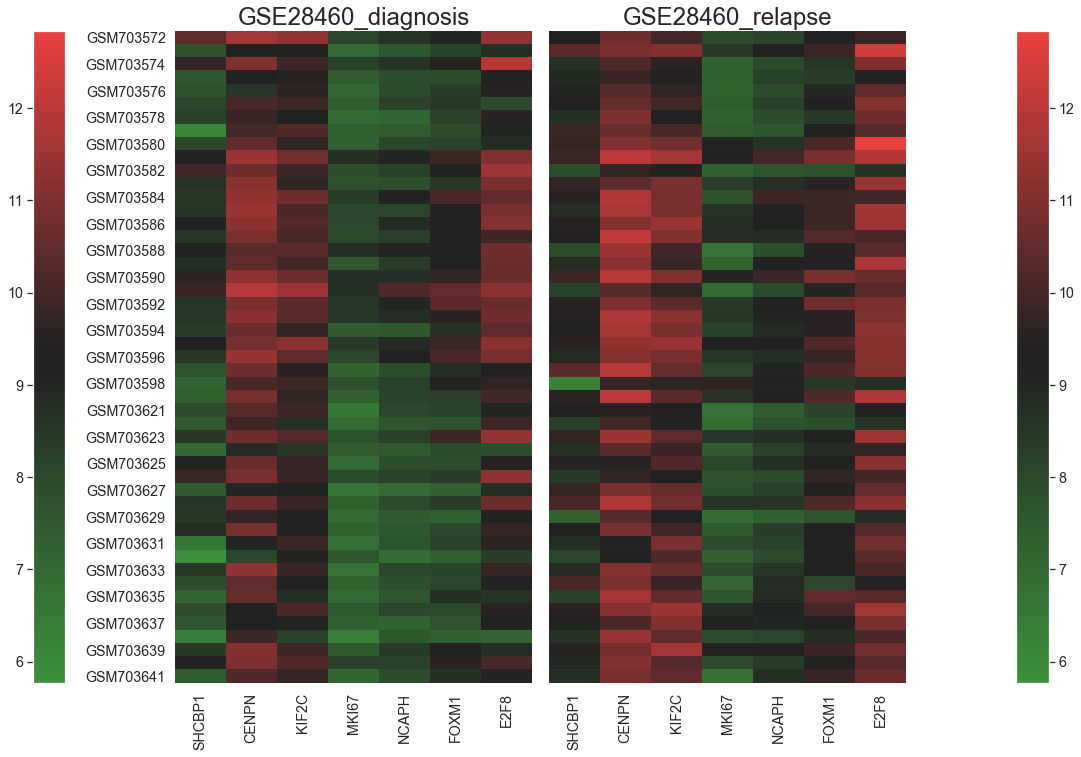

In [4]:
#heatmap
esets_d = pd.read_csv('./28460/esets_d.csv', index_col=0).T
esets_r = pd.read_csv('./28460/esets_r.csv', index_col=0).T

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (20, 12))
fig.subplots_adjust(wspace=0.03)

sns.heatmap(esets_d, ax=ax1, cmap=pal, cbar_kws={'label': 'log2 expression value'}, 
            cbar=False, vmin=min(esets_d.min().min(), esets_r.min().min()), 
            vmax=max(esets_d.max().max(), esets_r.max().max())).set_title('GSE28460_diagnosis', fontsize=24)

fig.colorbar(ax1.collections[0], ax=ax1, location="left", use_gridspec=False, pad=0.2)
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)

sns.heatmap(esets_r, ax=ax2, cmap=pal, cbar_kws={'label': 'log2 expression value'}, 
            cbar=False, yticklabels=False, vmin=min(esets_d.min().min(), esets_r.min().min()), 
            vmax=max(esets_d.max().max(), esets_r.max().max())).set_title('GSE28460_relapse', fontsize=24)

fig.colorbar(ax2.collections[0], ax=ax2, location="right", use_gridspec=False, pad=0.2)
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)

plt.savefig('./heatmap_gse28460.png', dpi=300, bbox_inches='tight')

---
## GSE69026

In [5]:
%%R
#DEG analysis

gse <- getGEO("GSE60926",GSEMatrix=TRUE)
gse <- gse[[1]]

#exp data
eset <- exprs(gse)

#probe id to gene symbol
fset <- fData(gse)

symbols <- fset[,"Gene Symbol"]
rownames(eset) <- symbols

pset <- phenoData(gse)

eset2 = t(eset)


pset3 = pset[pset$'source_name_ch1' != 'ALL - CNS - Relapse']
eset2 = eset2[pset$'source_name_ch1' != 'ALL - CNS - Relapse',]


eset2 = t(eset2)

grp <- pset3$'source_name_ch1'
design <- model.matrix(~0 + grp)
design = design[,1:2]
colnames(design)

colnames(design) <- c("diagnosis","relapse")

#fit
fit <- lmFit(eset2,design)
cont <- makeContrasts(relapse-diagnosis,levels=design)
fit.cont <- contrasts.fit(fit,cont)
fit.cont <- eBayes(fit.cont)
res <- topTable(fit.cont,number=Inf)

#data output
write.csv(res, file="res.csv")


#eset for visualization
genes = c('SHCBP1', 'CENPN', 'KIF2C', 'MKI67', 'NCAPH', 'FOXM1', 'E2F8')

eset60926 = eset[genes,]

eset_d = eset60926[,pset$'source_name_ch1' == 'ALL - bone marrow - Diagnosis']
eset_r = eset60926[,pset$'source_name_ch1' == 'ALL - bone marrow - Relapse']

# esets = data.frame('Diagnodis' = rowMeans(eset_d), 'Relapse' = rowMeans(eset_r))
#eset60926 = data.frame(t(eset60926))

# write.csv(esets, file='./60926/esets.csv')
# write.csv(eset60926, file='./60926/eset60926.csv')

write.csv(eset_d, file='./60926/esets_d.csv')
write.csv(eset_r, file='./60926/esets_r.csv')

In [6]:
#DEG cutoff
deg = pd.read_csv('./60926/res.csv')

print('deg----------------------------')
deg_pl = degpl(deg)
deg_mi = degmi(deg)

deg_pl.to_csv('./60926/deg_pl.csv')
deg_mi.to_csv('./60926/deg_mi.csv')

deg----------------------------
deg_pl:  (139, 8)
deg_mi:  (47, 8)


C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


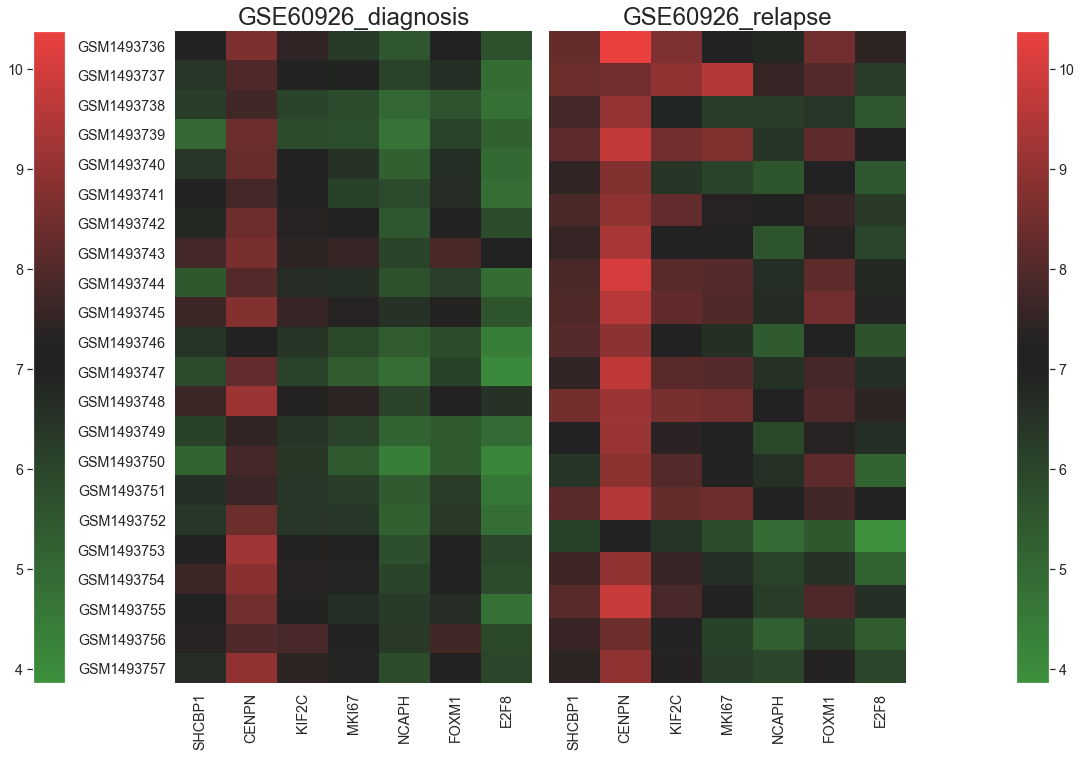

In [7]:
#heatmap
esets_d = pd.read_csv('./60926/esets_d.csv', index_col=0).T
esets_r = pd.read_csv('./60926/esets_r.csv', index_col=0).T

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (20, 12))
fig.subplots_adjust(wspace=0.03)

sns.heatmap(esets_d, ax=ax1, cmap=pal, cbar_kws={'label': 'log2 expression value'}, 
            cbar=False, vmin=min(esets_d.min().min(), esets_r.min().min()), 
            vmax=max(esets_d.max().max(), esets_r.max().max())).set_title('GSE60926_diagnosis', fontsize=24)

fig.colorbar(ax1.collections[0], ax=ax1, location="left", use_gridspec=False, pad=0.2)
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)

sns.heatmap(esets_r, ax=ax2, cmap=pal, cbar_kws={'label': 'log2 expression value'}, 
            cbar=False, yticklabels=False, vmin=min(esets_d.min().min(), esets_r.min().min()), 
            vmax=max(esets_d.max().max(), esets_r.max().max())).set_title('GSE60926_relapse', fontsize=24)

fig.colorbar(ax2.collections[0], ax=ax2, location="right", use_gridspec=False, pad=0.2)
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)

plt.savefig('./heatmap_gse60926.png', dpi=300, bbox_inches='tight')

---
## TARGET-ALL

In [8]:
#data input
table = pd.read_csv("./cBioPotal/all_phase2_target_2018_pub_(pediatric)/all_phase2_target_2018_pub_clinical_data.csv")
rna = pd.read_csv("./cBioPotal/all_phase2_target_2018_pub_(pediatric)/data_expression_median.txt", sep = '\t', header = None).T

rna.columns = rna.iloc[0,:]
rna = rna[2:]

table = pd.merge(table, rna, left_on = 'Sample ID', right_on = 'Hugo_Symbol')

#########################################non-paired sample
m = table['Sample ID'].str.contains('-04') == True
m2 = table['Sample ID'].str.contains('-09') == True

paired = pd.concat([table[m], table[m2]])
paired = paired.sort_values(by='Sample ID').reset_index()

paired['Relapse'] = paired['Sample ID'].str.contains('-04') == True

#data output
eset = paired.loc[:,'DDR1':'LOC652743']
pset = paired.loc[:, ['Sample ID', 'Relapse']]

#nomalize
eset2 = eset.apply(pd.to_numeric, errors='coerce')
eset2 = eset2.apply(lambda x: np.log2(x)) 

eset2.to_csv('./cBioPotal/all_phase2_target_2018_pub_(pediatric)/eset.csv')
pset.to_csv('./cBioPotal/all_phase2_target_2018_pub_(pediatric)/pset.csv')

C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249

In [9]:
%%R
#DEG analysis
eset = t(read.csv('./cBioPotal/all_phase2_target_2018_pub_(pediatric)/eset.csv'))
pset = read.csv('./cBioPotal/all_phase2_target_2018_pub_(pediatric)/pset.csv')

colnames(eset) <- eset[1,]

eset <- eset[-1,]

col1 = as.integer(pset['Relapse'] == 'False')
col2 = as.integer(pset['Relapse'] == 'True')

design = data.frame(col1, col2)

colnames(design) <- c("ctrl","relapse")

#fit
fit <- lmFit(eset,design)
cont <- makeContrasts(relapse-ctrl,levels=design)
fit.cont <- contrasts.fit(fit,cont)
fit.cont <- eBayes(fit.cont)
res <- topTable(fit.cont,number=Inf)

write.csv(res, file='./cBioPotal/all_phase2_target_2018_pub_(pediatric)/res.csv')


#eset for visualization
genes = c('SHCBP1', 'CENPN', 'KIF2C', 'MKI67', 'NCAPH', 'FOXM1', 'E2F8')

eset_target = eset[genes,]

eset_d = eset_target[,pset['Relapse'] == 'False']
eset_r = eset_target[,pset['Relapse'] == 'True']

# esets = data.frame('Diagnodis' = rowMeans(eset_d), 'Relapse' = rowMeans(eset_r))
# eset_target = data.frame(t(eset_target))

# write.csv(esets, file='./cBioPotal/all_phase2_target_2018_pub_(pediatric)/esets.csv')
# write.csv(eset_target, file='./cBioPotal/all_phase2_target_2018_pub_(pediatric)/eset_target.csv')

write.csv(eset_d, file='./cBioPotal/all_phase2_target_2018_pub_(pediatric)/esets_d.csv')
write.csv(eset_r, file='./cBioPotal/all_phase2_target_2018_pub_(pediatric)/esets_r.csv')

In [10]:
#DEG cutoff
deg = pd.read_csv('./cBioPotal/all_phase2_target_2018_pub_(pediatric)/res.csv')

print('deg----------------------------')
deg_pl = degpl(deg)
deg_mi = degmi(deg)

deg_pl.to_csv('./cBioPotal/all_phase2_target_2018_pub_(pediatric)/deg_pl.csv')
deg_mi.to_csv('./cBioPotal/all_phase2_target_2018_pub_(pediatric)/deg_mi.csv')

deg----------------------------
deg_pl:  (597, 7)
deg_mi:  (369, 7)


C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


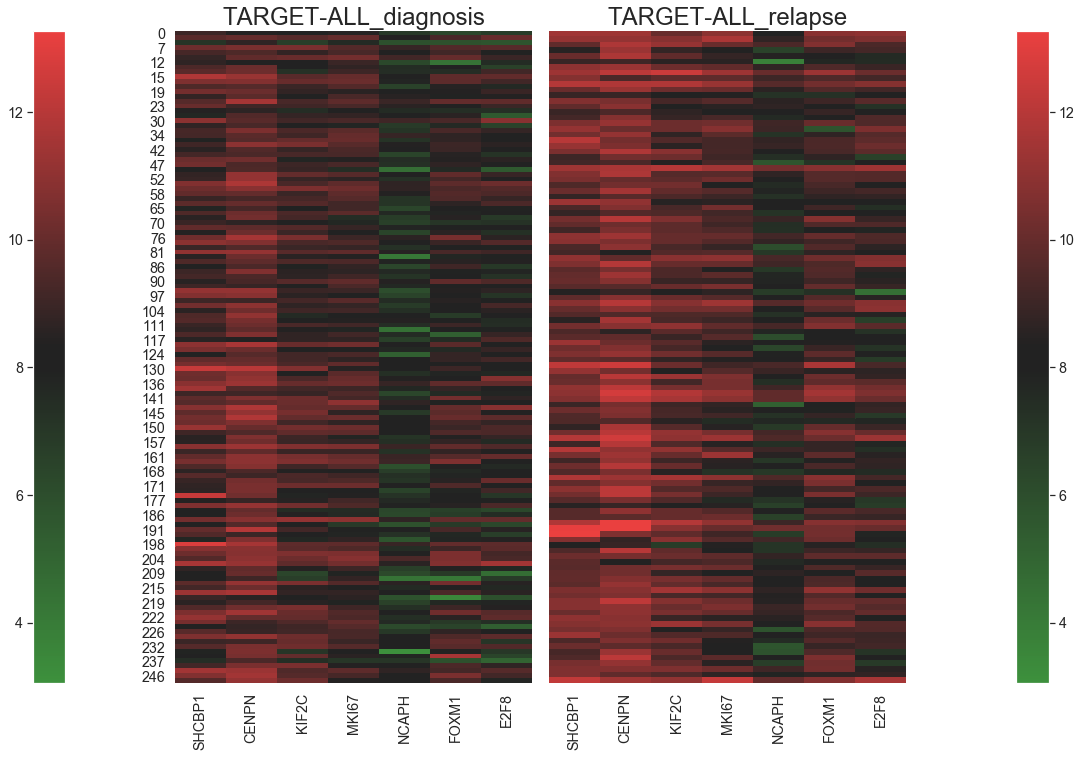

In [11]:
#heatmap
esets_d = pd.read_csv('./cBioPotal/all_phase2_target_2018_pub_(pediatric)/esets_d.csv', index_col=0).T
esets_r = pd.read_csv('./cBioPotal/all_phase2_target_2018_pub_(pediatric)/esets_r.csv', index_col=0).T

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (20, 12))
fig.subplots_adjust(wspace=0.03)

sns.heatmap(esets_d, ax=ax1, cmap=pal, cbar_kws={'label': 'log2 expression value'}, 
            cbar=False, vmin=min(esets_d.min().min(), esets_r.min().min()), 
            vmax=max(esets_d.max().max(), esets_r.max().max())).set_title('TARGET-ALL_diagnosis', fontsize=24)

fig.colorbar(ax1.collections[0], ax=ax1, location="left", use_gridspec=False, pad=0.2)
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)

sns.heatmap(esets_r, ax=ax2, cmap=pal, cbar_kws={'label': 'log2 expression value'}, 
            cbar=False, yticklabels=False, vmin=min(esets_d.min().min(), esets_r.min().min()), 
            vmax=max(esets_d.max().max(), esets_r.max().max())).set_title('TARGET-ALL_relapse', fontsize=24)

fig.colorbar(ax2.collections[0], ax=ax2, location="right", use_gridspec=False, pad=0.2)
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)

plt.savefig('./heatmap_TARGET.png', dpi=300, bbox_inches='tight')

---
## common DEGs

In [12]:
#pl
gse28460_pl = pd.read_csv("./28460/deg_pl.csv")
gse60926_pl = pd.read_csv("./60926/deg_pl.csv")
target_pl = pd.read_csv("./cBioPotal/all_phase2_target_2018_pub_(pediatric)/deg_pl.csv")
target_pl.rename(columns = {"Unnamed: 0.1": "ID"}, inplace = True)

#mi
gse28460_mi = pd.read_csv("./28460/deg_mi.csv")
gse60926_mi = pd.read_csv("./60926/deg_mi.csv")
target_mi = pd.read_csv("./cBioPotal/all_phase2_target_2018_pub_(pediatric)/deg_mi.csv")
target_mi.rename(columns = {"Unnamed: 0.1": "ID"}, inplace = True)

#merge
merge_pl = pd.merge(gse28460_pl, target_pl, on = 'ID')
merge_pl = pd.merge(gse60926_pl, merge_pl, on = 'ID')
merge_pl = merge_pl.drop_duplicates(['ID'])
merge_pl.to_csv('./DEG_merge/merge_pl.csv')

merge_mi = pd.merge(gse28460_mi, gse60926_mi, on = 'ID')
merge_mi = pd.merge(target_mi, merge_mi, on = 'ID')
merge_mi = merge_mi.drop_duplicates(['ID'])
merge_mi.to_csv('./DEG_merge/merge_mi.csv')

---
## Violinplot

In [13]:
e_28460 = pd.read_csv('./28460/eset28460.csv', index_col=0)
e_60926 = pd.read_csv('./60926/eset60926.csv', index_col=0)
e_target = pd.read_csv('./cBioPotal/all_phase2_target_2018_pub_(pediatric)/eset_target.csv', index_col=0)

C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


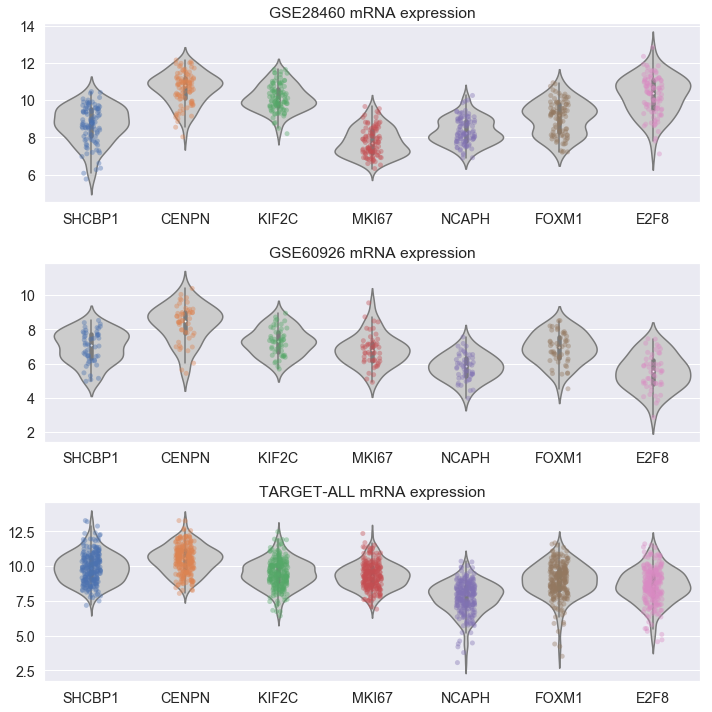

In [14]:
esets = [e_28460, e_60926, e_target]
esets2 = ['GSE28460', 'GSE60926', 'TARGET-ALL']

f, axes = plt.subplots(3, 1, figsize=(10,10))
j=0

for i in esets:
    axes[j].set_title('%s mRNA expression' %esets2[j])
    sns.violinplot(data=i, color="0.8", ax=axes[j], scale='width')
    sns.stripplot(data=i, jitter=True, alpha=0.4, ax=axes[j])
    plt.tight_layout(h_pad=2)
    j=j+1
    
f.savefig('./violinplot.png', dpi=300)

---
## ORA

In [15]:
ora = pd.read_csv('./DEG_merge/p001/ORA_results_pl.tsv', sep='\t')

ora2 = ora[['p-value', 'q-value', 'pathway']]
ora2 = ora2.set_index('pathway')

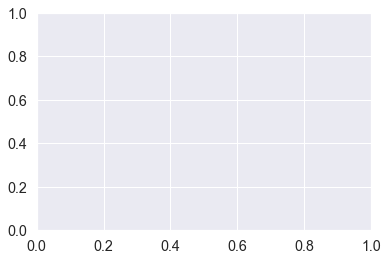

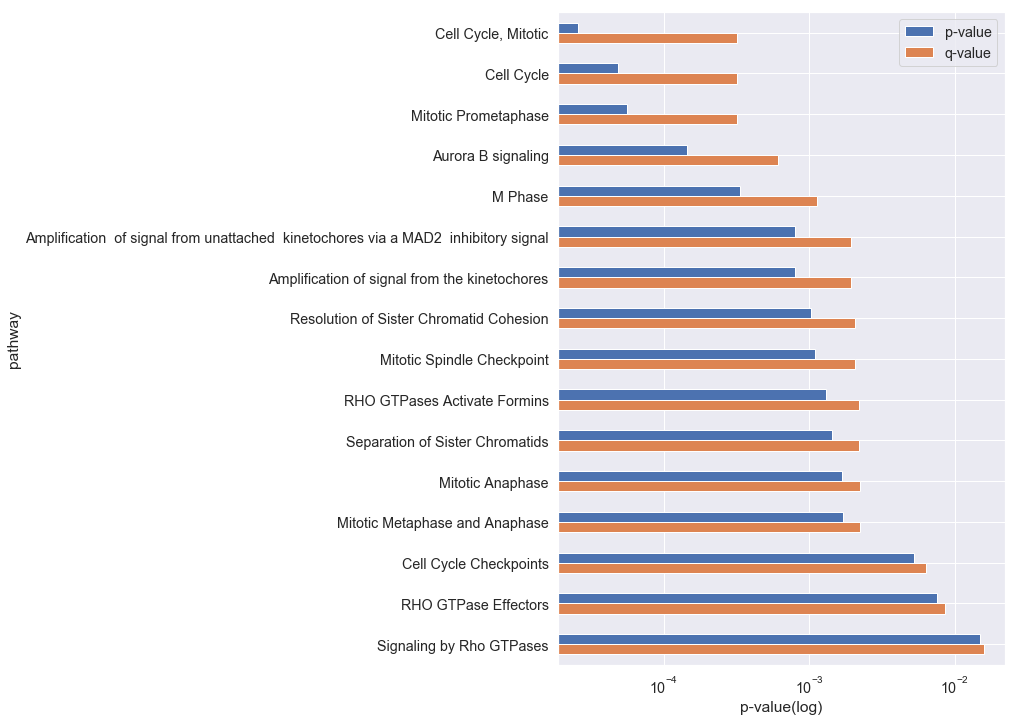

In [20]:
plt.subplots()

ax = ora2.plot(kind = 'barh', figsize = (8,12), logx = True)
ax.set(xlabel = 'p-value(log)')
ax.invert_yaxis()

plt.savefig('./ORA.png', dpi=300, bbox_inches='tight')

---
## GSE28460_volcanoplot

C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessor

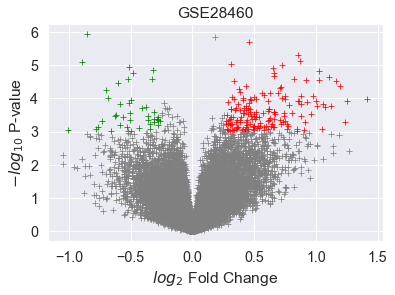

In [17]:
res = pd.read_csv('./28460/res.csv')
plotprocess()

f1 = sns.scatterplot('logFC', 'logPV', marker='+', hue='type', data = res, palette = {'mi':'green', 'pl':'red', 'etc':'gray'}, legend = False)
# f1.vlines (1, 0, 9, colors = 'black')
# f1.vlines (-1, 0, 9, colors = 'black')
# f1.hlines (-(math.log10(0.05)), -20, 20, colors = 'black')
# axes = f1.axes
# f1.set_xlim(-20,20)
# f1.set_ylim(0, 6.5)

plt.title('GSE28460')
plt.xlabel('${log_{2}}$ Fold Change')
plt.ylabel('${-log_{10}}$ P-value')

plt.savefig('./volcano_gse28460.png', dpi=300)

---
## GSE60926_volcanoplot

C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessor

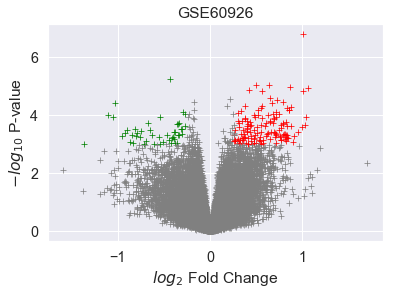

In [18]:
res = pd.read_csv('./60926/res.csv')
plotprocess()

f1 = sns.scatterplot('logFC', 'logPV', marker='+', hue='type', data = res, palette = {'mi':'green', 'pl':'red', 'etc':'gray'}, legend = False)

plt.title('GSE60926')
plt.xlabel('${log_{2}}$ Fold Change')
plt.ylabel('${-log_{10}}$ P-value')

plt.savefig('./volcano_gse60926.png', dpi=300)

---
## TARGET-ALL_volcanoplot

C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessor

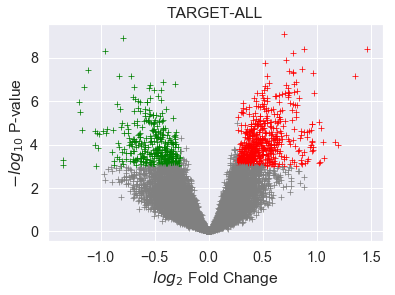

In [19]:
res = pd.read_csv('./cBioPotal/all_phase2_target_2018_pub_(pediatric)/res.csv')
plotprocess()

f1 = sns.scatterplot('logFC', 'logPV', marker='+', hue='type', data = res, palette = {'mi':'green', 'pl':'red', 'etc':'gray'}, legend = False)

plt.title('TARGET-ALL')
plt.xlabel('${log_{2}}$ Fold Change')
plt.ylabel('${-log_{10}}$ P-value')

plt.savefig('./volcano_target.png', dpi=300)